In [2]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import shap
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import plotly.express as px



from catboost import CatBoostRegressor

import random
random.seed(42)  # For reproducibility

In [3]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [4]:
folder_path = 'data/horse-tracking-data'
derby_path = 'data/big-data-derby-2022'
# List to store filenames and paths
def get_files(folder_path):
    file_list = []
    race_list = []
    # Iterate through the folder
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.csv'):  # Check if the file is a CSV
                full_path = os.path.join(root, file)
                file_list.append(full_path)
                race_list.append(file.split('.')[0])

    # print(file_list)
    # print(race_list)
    return file_list, race_list


def train_test_file_split(file_list):
    random.shuffle(file_list)

    split_index = int(0.8 * len(file_list))
    train_files = file_list[:split_index]
    test_files = file_list[split_index:]

    print(f"Total Files : {len(file_list)}")
    print(f"Number of training files: {len(train_files)}")
    print(f"Number of testing files: {len(test_files)}")

    return train_files, test_files

In [5]:
file_list, race_list = get_files(folder_path)
train_files, test_files = train_test_file_split(file_list)

Total Files : 1994
Number of training files: 1595
Number of testing files: 399


In [6]:
def calculate_leader_differences_horse(group):
    # group is of a horse data
    group = group.sort_values('trakus_index')
    final_distance_to_leader = list(group['distance_to_leader'])[-1]
    group['distance_differences'] = group['distance_to_leader'] - final_distance_to_leader
    group['distance_differences'] = group['distance_differences']/group['leader_remaining_distance']    

    return group

In [7]:
feature_columns = [
        'position', 'cumulative_distance_travelled',

        'distance_to_leader',
         'speed_1s','acceleration_1s', 
       
    #    'speed_1s_lag1', 'speed_1s_lag2', 'speed_1s_lag3', 
       
    #    'acceleration_1s_lag1','acceleration_1s_lag2', 'acceleration_1s_lag3',

        # 'distance_to_leader_lag1', 'distance_to_leader_lag2', 'distance_to_leader_lag3',
        'remaining_distance',
        'leader_remaining_distance',
        ] 
        
        # 'curve'] # from the updated column

target = ['target_variable']

In [8]:
def create_sequences(data, target, window_size):
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size])
        targets.append(target[i + window_size])  # The target at time t+1
    return np.array(sequences), np.array(targets)



def create_sequential_data(file_list):
    X =  []
    y = []
    for file in tqdm(file_list):
        race_data = pd.read_csv(file)
        # remove invalid rows after race end
        race_data = race_data[race_data['is_race_going']]

        # create target variable
        race_data['program_number'] = race_data['program_number'].astype(str).str.strip()
        race_data = race_data.groupby('program_number').apply(calculate_leader_differences_horse)

        # for each horse (program number) worth of data in race, sort it by trakus index and pass thorugh create_sequence
        for program_number in race_data['program_number'].unique():
            
            program_data = race_data[race_data['program_number']==program_number].reset_index(drop=True)
            sequences, targets = create_sequences(program_data[feature_columns].values, program_data[target].values, window_size=8)
            X.extend(sequences)
            y.extend(targets)
    

    return np.array(X), np.array(y)        
        

In [9]:
X_train, Y_train = create_sequential_data(train_files)
X_test, Y_test = create_sequential_data(test_files)

  0%|          | 0/1595 [00:00<?, ?it/s]

100%|██████████| 399/399 [00:06<00:00, 60.37it/s]


In [10]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((3618534, 8, 7), (3618534, 1), (890621, 8, 7), (890621, 1))

In [11]:
Y_train = pd.DataFrame(Y_train, columns=['distance_differences'])
Y_test = pd.DataFrame(Y_test, columns=['distance_differences'])

Y_train['distance_differences'] = Y_train['distance_differences'].apply(lambda x : 0 if x<0 else 0.999999 if x>=1 else x)
Y_test['distance_differences'] = Y_test['distance_differences'].apply(lambda x : 0 if x<0 else 0.999999 if x>=1 else x)


In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_reshaped = X_train.reshape(-1, X_train.shape[2])
X_test_reshaped = X_test.reshape(-1, X_test.shape[2])

X_train_scaled = scaler.fit_transform(X_train_reshaped)  # NumPy array
X_test_scaled = scaler.transform(X_test_reshaped)

X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)
# # Convert back to DataFrame
# X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
# X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


In [41]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


window_size = 8

# Build the model
model = Sequential()

# Add LSTM layer
model.add(LSTM(10, activation='relu', input_shape=(window_size, X_train.shape[2])))

# Add Dropout layer to prevent overfitting
model.add(Dropout(0.2))

# Add Dense output layer
model.add(Dense(1))  # For regression, single target

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train_scaled, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test))


/opt/anaconda3/envs/DSFEnv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
113080/113080 ━━━━━━━━━━━━━━━━━━━━ 92s 812us/step - loss: 0.1191 - val_loss: 0.6740
Epoch 2/10
113080/113080 ━━━━━━━━━━━━━━━━━━━━ 89s 785us/step - loss: 1.3580e-04 - val_loss: 0.5650
Epoch 3/10
113080/113080 ━━━━━━━━━━━━━━━━━━━━ 88s 781us/step - loss: 1.3071e-04 - val_loss: 1.1878
Epoch 4/10
113080/113080 ━━━━━━━━━━━━━━━━━━━━ 89s 786us/step - loss: 1.4058e-04 - val_loss: 0.3095
Epoch 5/10
113080/113080 ━━━━━━━━━━━━━━━━━━━━ 89s 790us/step - loss: 1.4633e-04 - val_loss: 0.2921
Epoch 6/10
113080/113080 ━━━━━━━━━━━━━━━━━━━━ 89s 787us/step - loss: 1.3200e-04 - val_loss: 0.2858
Epoch 7/10
113080/113080 ━━━━━━━━━━━━━━━━━━━━ 89s 786us/step - loss: 1.3710e-04 - val_loss: 0.2803
Epoch 8/10
113080/113080 ━━━━━━━━━━━━━━━━━━━━ 89s 787us/step - loss: 1.3751e-04 - val_loss: 0.3731
Epoch 9/10
113080/113080 ━━━━━━━━━━━━━━━━━━━━ 91s 802us/step - loss: 1.3660e-04 - val_loss: 0.8308
Epoch 10/10
113080/113080 ━━━━━━━━━━━━━━━━━━━━ 93s 819us/step - loss: 1.3471e-04 - val_loss: 1.7332


In [42]:
# Evaluate on test data
loss = model.evaluate(X_test_scaled, Y_test)
print(f"Test Loss: {loss}")

# Make predictions
y_pred = model.predict(X_test_scaled)

27832/27832 ━━━━━━━━━━━━━━━━━━━━ 8s 279us/step - loss: 1.3298e-04
Test Loss: 0.00014277282753027976
27832/27832 ━━━━━━━━━━━━━━━━━━━━ 10s 344us/step


### Plotting Stuff

In [29]:
# Do bernoulli here
def plotter(win_prob, rank_, remain_, race_name, save_folder):
    if race_name != "":
        base_name = os.path.splitext(race_name)[0]  # Removes the file extension
        file_name = f"{base_name}.png"
        file_name = file_name.split("/")[-1]

        save_path = os.path.join(save_folder, file_name)


    fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=False)

    df_win = win_prob.reset_index().melt(id_vars='trakus_index', 
                                  var_name='program_number', 
                                  value_name='win_probability')

    # df_win['smooth_win_probability'] = df_win.groupby('program_number')['win_probability'].transform(
    # lambda x: x.rolling(window=5, min_periods=1).mean()
    # )
    # Plot 1: Win Probabilities
    sns.lineplot(
        data=df_win, 
        x='trakus_index', 
        y='win_probability', 
        hue='program_number', 
        ax=axes[0]
    )
    axes[0].set_title("Win Probabilities Over Time")
    axes[0].set_xlabel("Time (Trakus Index)")
    axes[0].set_ylabel("Win Probability")
    axes[0].legend(title="Program Number")

    df_rank = rank_.reset_index().melt(id_vars='trakus_index', 
                                  var_name='program_number', 
                                  value_name='position')

    # Plot 2: Positions
    sns.lineplot(
        data=df_rank, 
        x='trakus_index', 
        y='position', 
        hue='program_number', 
        ax=axes[1]
    )
    axes[1].set_title("Positions Over Time")
    axes[1].set_xlabel("Time (Trakus Index)")
    axes[1].set_ylabel("Position")
    axes[1].legend(title="Program Number")


    df_remaining_dist = remain_.reset_index().melt(id_vars='trakus_index', 
                                  var_name='program_number', 
                                  value_name='distance_to_leader')
    # Plot 3: Distance to Leader
    sns.lineplot(
        data=df_remaining_dist, 
        x='trakus_index', 
        y='distance_to_leader', 
        hue='program_number', 
        ax=axes[2]
    )
    axes[2].set_title("Distance to Leader Over Time")
    axes[2].set_xlabel("Time (Trakus Index)")
    axes[2].set_ylabel("Distance to Leader")
    axes[2].legend(title="Program Number")

    fig.suptitle(race_name)
    

    # Adjust layout
    # plt.tight_layout()
    # print("Saving image to : ", save_path)
        # plt.savefig(save_path, dpi=300, bbox_inches='tight')

    # plt.close(fig)

### Bernoulli

In [30]:
def bernoulli_race(race_data):
    # dataframe containing one race worth of data
    # for each trakus index, calculate prob for each hors
    # return dataframe
    
    # the reace I cwill get here will be after passing it to model already
    race_data.sort_values('trakus_index', inplace=True)
    race_data = race_data.reset_index()

    # convert to string representation
    race_data['program_number'] = race_data['program_number'].astype(str).str.strip()

    # brenoulli now
    size = 1000
    rank_ = pd.pivot_table(race_data, index='trakus_index', columns='program_number', values='distance_to_leader')
    remain_ = pd.pivot_table(race_data, index='trakus_index', columns='program_number', values='leader_remaining_distance')
    pred_ = pd.pivot_table(race_data, index='trakus_index', columns='program_number', values='distance_differences')
    pos_ = pd.pivot_table(race_data, index='trakus_index', columns='program_number', values='position')


    win_prob = pred_.copy() 

    total_rows = win_prob.shape[0]
    error_rows = 0

    for i, row in pred_.iterrows():
        cur_win_prob = pd.DataFrame(index=range(size))
        for fp in pred_.columns:
            
            if remain_.loc[i][fp] < 0:
                cur_win_prob[fp] = [1]*1000
                continue
            try:
               
                fp_dist_diff = np.random.binomial(remain_.loc[i][fp], row[fp], size)
            except Exception as e:
                # print("Error occurred during Bernoulli race calculation for race. , error : " + str(e))
                # print current variable values
                # print(f"Status: Rem : {remain_.loc[i][fp]} || Target: {row[fp]}")
                error_rows += 1
            
            
            pred_rank = rank_.loc[i][fp] - fp_dist_diff
            cur_win_prob[fp] = pred_rank
        # cur_win_prob = cur_win_prob.rank(method='min', axis=1)
        for fp in pred_.columns:
            win_prob.loc[i, fp] = sum(cur_win_prob[fp]<=0) / size

    # norm
    win_prob = win_prob.divide(win_prob.sum(axis=1), axis=0)

    # if error_rows > 0:
        # print(f"Error occurred {error_rows} times during Bernoulli race calculation. ({error_rows/total_rows} %)")

    return win_prob, rank_



def bernoulli_super(file_list, model, scalar,save_folder):
    # multiple files
    # read each file, pass through model to predict target
    # take target df for the race, pass to bernoulli_race to get probabilities for that, store. 

    os.makedirs(save_folder, exist_ok=True)


    for file in tqdm(file_list):
        # print("For Race : " + str(file))
        race_data = pd.read_csv(file)
        race_data = race_data[race_data['is_race_going']]
        race_features = scalar.transform(race_data[feature_columns])
        race_data['distance_differences'] = model.predict(race_features)
        race_data['distance_differences'] = race_data['distance_differences'].apply(lambda x : 0 if x<0 else 0.999999 if x>=1 else x)
        # pass race_data to bernoulli race function
        win_prob, rank_ = bernoulli_race(race_data)
        # win_prob, rank_ = monte_carlo_wrapper(race_data)

        remain_ = pd.pivot_table(race_data, index='trakus_index', columns='program_number', values='distance_to_leader')

        # plot probabilities for that race
        plotter(win_prob, rank_, remain_, file, save_folder) 



In [14]:
# get race test data
file_list, race_list = get_files(folder_path)
train_set, test_set= train_test_file_split(file_list)

test_set = test_set[:10]

Total Files : 1994
Number of training files: 1595
Number of testing files: 399


In [15]:
race_data = test_set[0] 
race_data

'data/horse-tracking-data/BEL_2019-06-13_4.csv'

In [43]:
X_check, y_check = create_sequential_data([race_data])

100%|██████████| 1/1 [00:00<00:00, 34.42it/s]


In [17]:
y_pred = model.predict(X_check)

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step


In [44]:
race_df = pd.read_csv(race_data)
race_df = race_df[race_df['is_race_going']]
race_df['program_number'] = race_df['program_number'].astype(str).str.strip()


In [45]:
race_df

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,easting,northing,unique_id,...,acceleration_1s_lag2,acceleration_1s_lag3,distance_to_leader_lag1,distance_to_leader_lag2,distance_to_leader_lag3,remaining_distance,is_race_going,final_positions,leader_remaining_distance,target_variable
0,BEL,2019-06-13,4,1,1,40.712646,-73.719271,608179.105182,4.507648e+06,BEL_2019-06-13_4,...,0.000000,0.000000,0.000000,0.000000,0.000000,1709.928000,True,5,1709.928000,-0.001754
1,BEL,2019-06-13,4,1,2,40.712652,-73.719263,608179.758351,4.507648e+06,BEL_2019-06-13_4,...,0.000000,0.000000,0.000000,0.000000,0.000000,1708.949521,True,5,1708.443325,0.000000
2,BEL,2019-06-13,4,1,3,40.712659,-73.719255,608180.388755,4.507649e+06,BEL_2019-06-13_4,...,0.000000,0.000000,0.506196,0.000000,0.000000,1708.014274,True,5,1707.205329,0.000000
3,BEL,2019-06-13,4,1,4,40.712668,-73.719243,608181.392002,4.507650e+06,BEL_2019-06-13_4,...,0.000000,0.000000,0.808945,0.506196,0.000000,1706.574547,True,5,1705.537819,0.000586
4,BEL,2019-06-13,4,1,5,40.712679,-73.719228,608182.644031,4.507651e+06,BEL_2019-06-13_4,...,0.000000,0.000000,1.036729,0.808945,0.506196,1704.791096,True,5,1703.394266,0.000587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2754,BEL,2019-06-13,4,8,361,40.713915,-73.722970,607864.522726,4.507784e+06,BEL_2019-06-13_4,...,-0.532584,-0.153575,7.722641,7.508871,7.344187,25.444450,True,3,17.530590,0.000000
2755,BEL,2019-06-13,4,8,362,40.713902,-73.722916,607869.135652,4.507782e+06,BEL_2019-06-13_4,...,-0.536180,-0.532584,7.913860,7.722641,7.508871,20.613520,True,3,12.394932,0.000000
2756,BEL,2019-06-13,4,8,363,40.713888,-73.722861,607873.809008,4.507781e+06,BEL_2019-06-13_4,...,-0.319448,-0.536180,8.218588,7.913860,7.722641,15.713031,True,3,7.329546,0.000000
2757,BEL,2019-06-13,4,8,364,40.713874,-73.722806,607878.518285,4.507780e+06,BEL_2019-06-13_4,...,-0.351597,-0.319448,8.383485,8.218588,7.913860,10.772119,True,3,2.389772,0.000000


In [46]:
total_trakus_indices = race_df['trakus_index'].values[-1]
race_df = race_df.sort_values(['program_number', 'trakus_index'])

In [47]:
for i in range(window_size, total_trakus_indices+1):
    start_indx = i - window_size
    end_indx = i

    # get this data for all horses

    for program_id in race_df['program_number'].unique():
        program_data = race_df[race_df['program_number']==program_id]
        working_index = program_data[program_data['trakus_index']==end_indx].index.tolist()[0]
        # print(f"Working Index is : {working_index} for Trakus : {end_indx}")

        program_data = program_data.loc[working_index-window_size :working_index-1]
        # print program_data
        # print(program_data[feature_columns])
        program_features = scaler.transform(program_data[feature_columns].values)
        program_features = np.expand_dims(program_features, axis=0)


        # pass to model
        distance_differences = model.predict(program_features)



        race_df.loc[working_index, 'distance_differences'] = distance_differences




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/ste

In [49]:
race_df['distance_differences'].describe()

count    2506.000000
mean        0.001378
std         0.001572
min        -0.000440
25%         0.000251
50%         0.000893
75%         0.001770
max         0.007428
Name: distance_differences, dtype: float64

In [50]:
race_df[race_df['trakus_index']==365] #[['program_number','position']]

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,easting,northing,unique_id,...,acceleration_1s_lag3,distance_to_leader_lag1,distance_to_leader_lag2,distance_to_leader_lag3,remaining_distance,is_race_going,final_positions,leader_remaining_distance,target_variable,distance_differences
364,BEL,2019-06-13,4,1,365,40.713915,-73.722821,607877.166976,4.507784e+06,BEL_2019-06-13_4,...,0.056775,15.655673,15.365019,15.061646,13.449081,True,5,-2.68538,-0.000000,0.005757
763,BEL,2019-06-13,4,1A,365,40.713940,-73.722973,607864.288607,4.507787e+06,BEL_2019-06-13_4,...,-0.122133,28.645436,28.294102,27.722317,26.497802,True,7,-2.68538,0.372387,0.004906
1162,BEL,2019-06-13,4,2,365,40.713897,-73.722813,607877.846593,4.507782e+06,BEL_2019-06-13_4,...,0.031124,14.509920,14.336602,13.937760,12.199262,True,4,-2.68538,-0.000000,0.005282
1561,BEL,2019-06-13,4,3,365,40.713860,-73.722644,607892.216163,4.507778e+06,BEL_2019-06-13_4,...,0.125334,0.000000,0.000000,0.000000,-2.685380,True,1,-2.68538,-0.000000,0.001225
1960,BEL,2019-06-13,4,6,365,40.713858,-73.722696,607887.773574,4.507778e+06,BEL_2019-06-13_4,...,-0.051465,4.028116,3.951396,3.823918,1.449756,True,2,-2.68538,-0.000000,0.002921
2359,BEL,2019-06-13,4,7,365,40.713956,-73.722971,607864.416358,4.507788e+06,BEL_2019-06-13_4,...,-0.040638,29.281319,29.034358,28.621784,26.908590,True,6,-2.68538,-0.372387,0.005601
2758,BEL,2019-06-13,4,8,365,40.713861,-73.722751,607883.136906,4.507778e+06,BEL_2019-06-13_4,...,-0.351597,8.382346,8.383485,8.218588,5.924700,True,3,-2.68538,-0.000000,0.005539


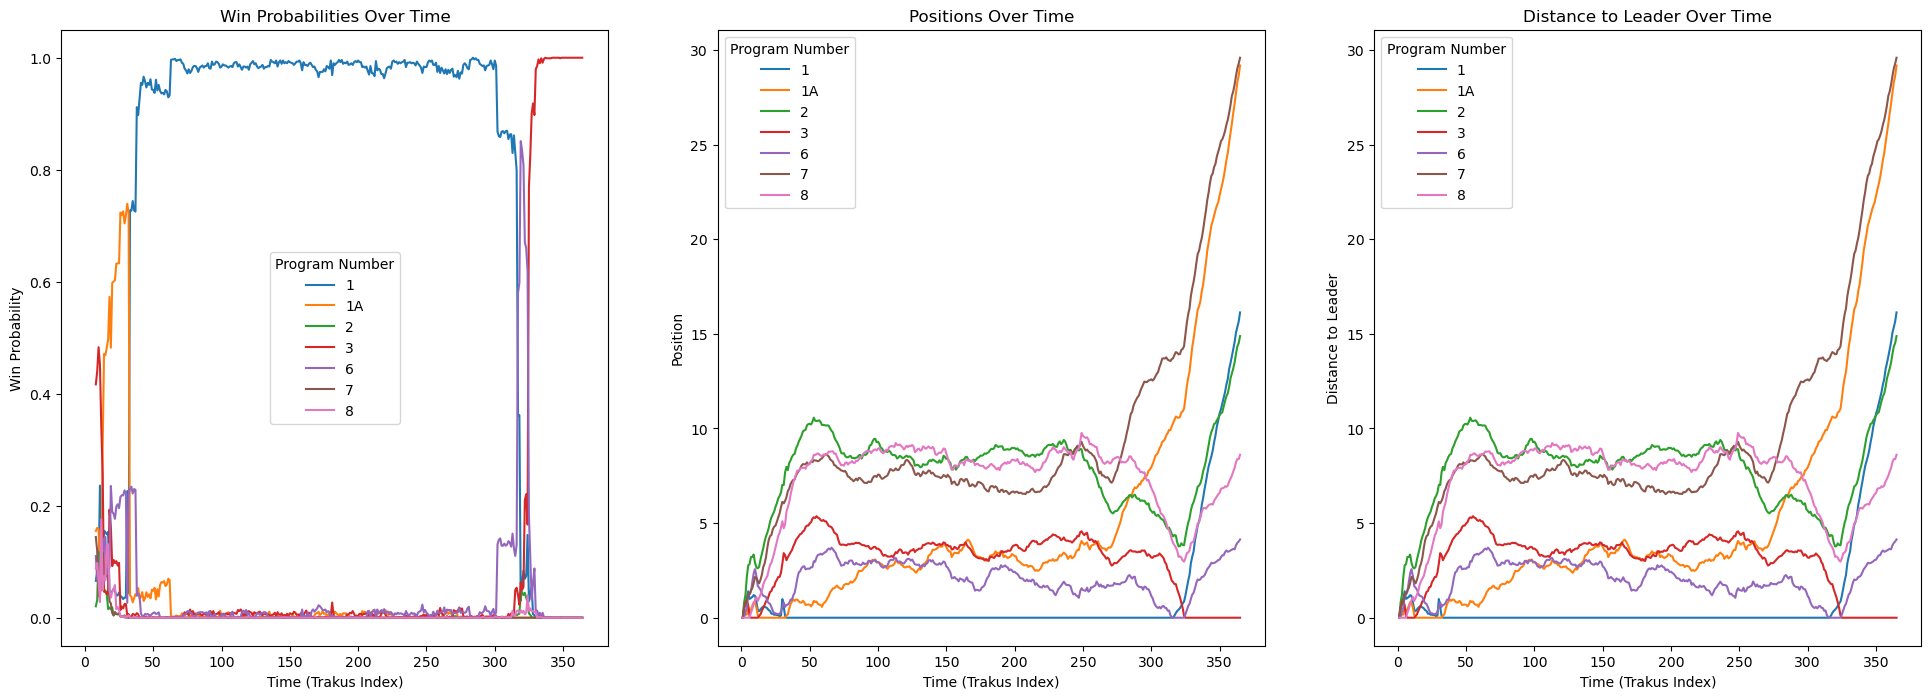

In [51]:
win_prob, rank_ = bernoulli_race(race_df)
remain_ = pd.pivot_table(race_df, index='trakus_index', columns='program_number', values='distance_to_leader')


plotter(win_prob, rank_, remain_, "", "") 


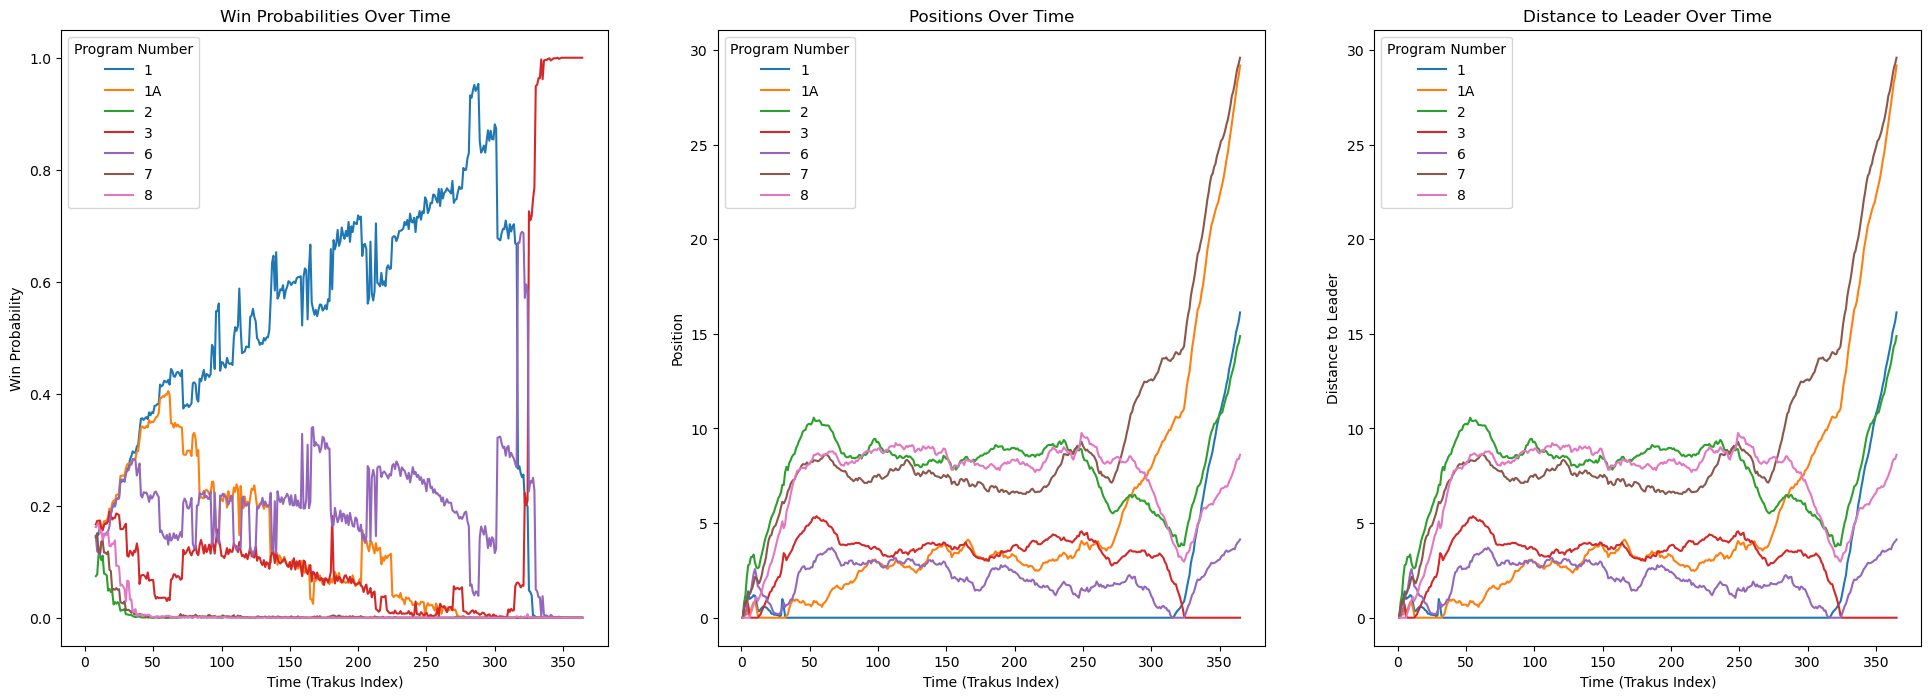

In [31]:
win_prob, rank_ = bernoulli_race(race_df)
remain_ = pd.pivot_table(race_df, index='trakus_index', columns='program_number', values='distance_to_leader')


plotter(win_prob, rank_, remain_, "", "") 


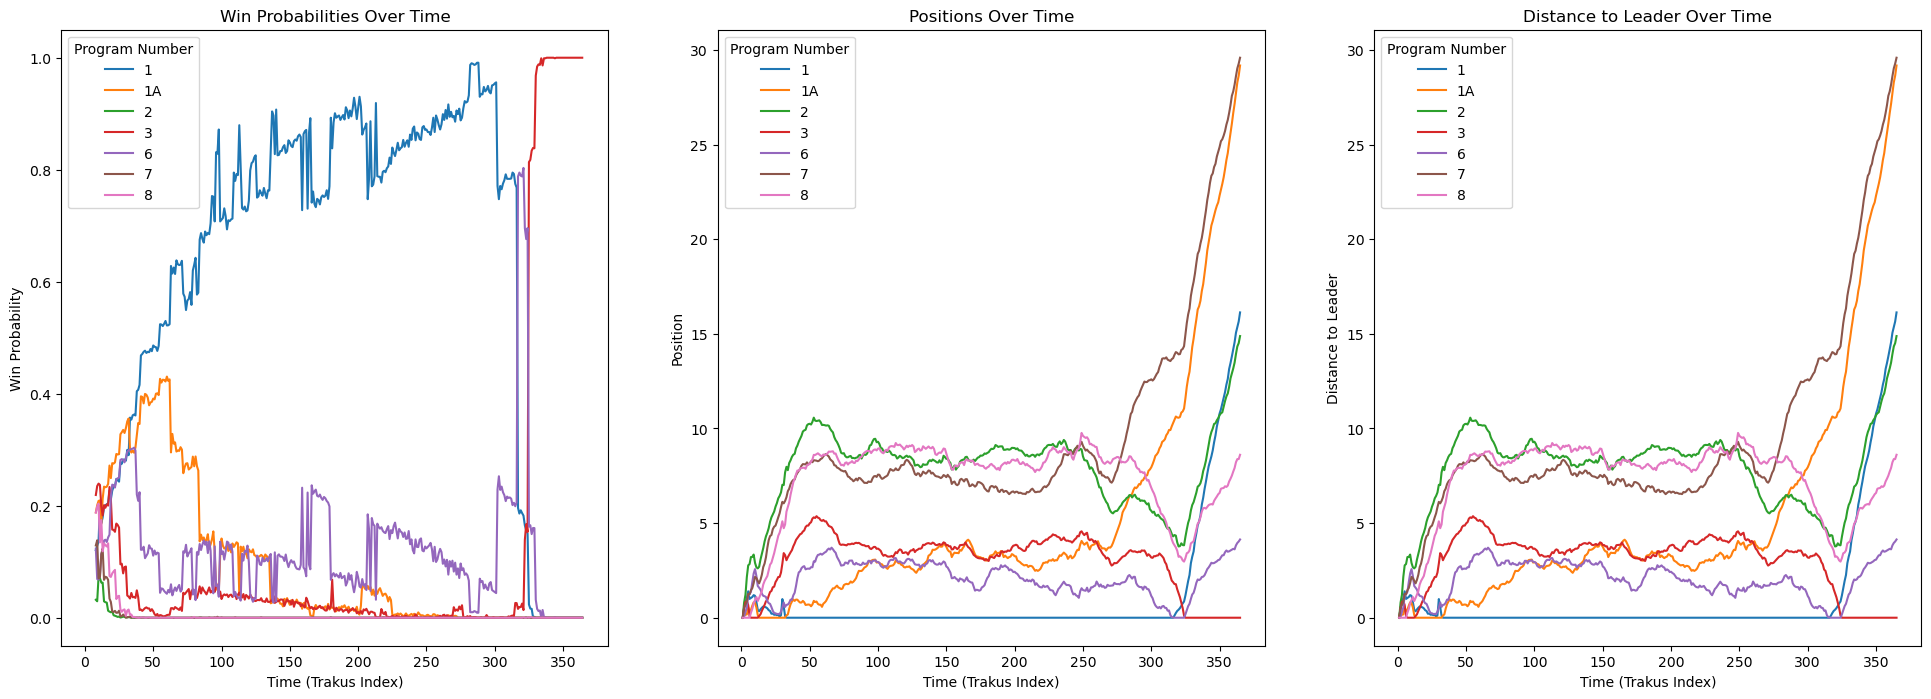

In [37]:
win_prob, rank_ = bernoulli_race(race_df)
remain_ = pd.pivot_table(race_df, index='trakus_index', columns='program_number', values='distance_to_leader')


plotter(win_prob, rank_, remain_, "", "") 
